# 2D Acoustic Wave Equation with Devito

This notebook simulates a 2D acoustic wave equation using Devito’s finite-difference DSL.
It sets up a homogeneous velocity model, injects a Ricker wavelet source, records a receiver,
and visualizes the wavefield and recorded trace.

In [1]:
# Optional: install dependencies if missing (uncomment if needed)
# Note: May require internet access.
# %pip install devito numpy matplotlib

import numpy as np
import matplotlib.pyplot as plt

import devito as dv
from devito import Grid, TimeFunction, Function, SparseTimeFunction, Eq, Operator

# Ensure consistent plotting style
plt.rcParams['figure.figsize'] = (6, 5)
plt.rcParams['image.cmap'] = 'seismic'
plt.rcParams['image.interpolation'] = 'bilinear'


## Parameters

In [2]:
# Domain and model parameters
nx, ny = 201, 201           # grid points
dx, dy = 10.0, 10.0         # grid spacing [m]
c0 = 2500.0                 # velocity [m/s] (homogeneous)

# Time parameters
tn = 1.0                    # total simulation time [s]
cfl = 0.4                   # CFL safety factor (<= ~0.5 for 2D, space_order=4)

# Source parameters
f0 = 10.0                   # Ricker peak frequency [Hz]
src_x_frac = 0.5            # source x location as fraction of domain length
src_y_frac = 0.5            # source y location as fraction of domain length
rec_x_frac = 0.75           # receiver x fraction
rec_y_frac = 0.5            # receiver y fraction

# Derived values
Lx, Ly = nx*dx, ny*dy
dt_est = cfl * min(dx, dy) / c0
nt = int(np.ceil(tn / dt_est)) + 1
dt = tn / (nt - 1)

print(f'Grid: {nx}x{ny}, dx={dx} m, dy={dy} m')
print(f'Velocity: {c0} m/s')
print(f'Time: tn={tn} s, nt={nt}, dt={dt:.6f} s')


Grid: 201x201, dx=10.0 m, dy=10.0 m
Velocity: 2500.0 m/s
Time: tn=1.0 s, nt=626, dt=0.001600 s


In [3]:
# Visualization parameters for color scaling
vis_percentile = 98.0   # percentile for robust amplitude (e.g., 95-99.5)
vis_clip_scale = 0.6    # additional scale to tighten the clip (0.3-1.0)
print(f'Visualization: percentile={vis_percentile}%, scale={vis_clip_scale}')


Visualization: percentile=98.0%, scale=0.6


## Model and fields

In [4]:
# Create computational grid
grid = Grid(shape=(nx, ny), extent=(Lx, Ly))

# Velocity model as a Function (constant here)
c = Function(name='c', grid=grid, space_order=0)
c.data[:] = c0

# Wavefield (TimeFunction) with saving of all timesteps for visualization
u = TimeFunction(name='u', grid=grid, time_order=2, space_order=4, save=nt)

# Source and receiver as SparseTimeFunctions
src = SparseTimeFunction(name='src', grid=grid, npoint=1, nt=nt, time_order=2)
rec = SparseTimeFunction(name='rec', grid=grid, npoint=1, nt=nt, time_order=2)

# Set source/receiver coordinates
src_x, src_y = src_x_frac * Lx, src_y_frac * Ly
rec_x, rec_y = rec_x_frac * Lx, rec_y_frac * Ly
src.coordinates.data[0, 0] = src_x
src.coordinates.data[0, 1] = src_y
rec.coordinates.data[0, 0] = rec_x
rec.coordinates.data[0, 1] = rec_y

# Ricker wavelet source time function
t = np.linspace(0.0, tn, nt)
t0 = 1.0 / f0
ricker = (1.0 - 2.0 * (np.pi * f0 * (t - t0))**2) * np.exp(-(np.pi * f0 * (t - t0))**2)
src.data[:, 0] = ricker

# Symbolic time step
dt_sym = grid.time_dim.spacing


## PDE, source injection, and operator

In [5]:
# 2D acoustic wave equation (second-order in time)
# u.forward = 2*u - u.backward + (c*dt)^2 * Laplace(u) + source_term
eq_time_update = Eq(u.forward, 2*u - u.backward + (c * dt_sym)**2 * u.laplace)

# Inject source term at grid point location
src_inject = src.inject(field=u.forward, expr=src * dt_sym**2)

# Interpolate wavefield to receiver location
rec_read = rec.interpolate(expr=u)

# Build operator
op = Operator([eq_time_update] + src_inject + rec_read)
op

Cpu64AdvCOperator[Kernel]<int; struct dataobj *,struct dataobj *,struct dataobj *,struct dataobj *,struct dataobj *,struct dataobj *,int,int,int,int,float,float,float,float,float,int,int,int,int,int,int,struct profiler *>

## Run simulation

In [6]:
# Execute for nt-2 steps (due to forward/backward indexing)
op(time=nt-2, dt=dt)

print('Simulation complete.')


Operator `Kernel` ran in 0.03 s


Simulation complete.


## Visualize wavefield and receiver trace

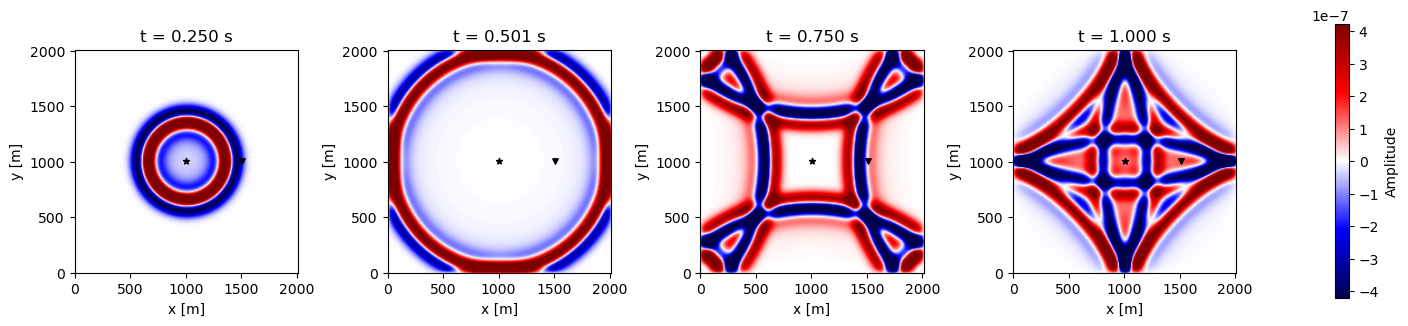

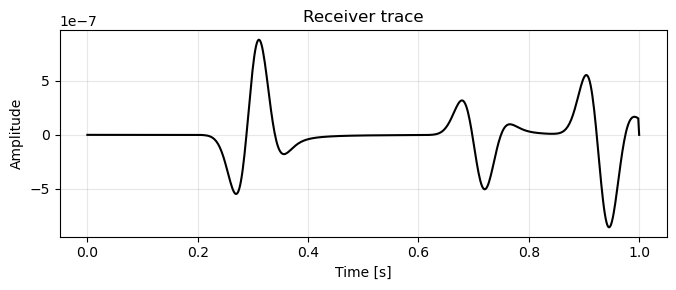

In [7]:
# Plot a few snapshots and the final wavefield
snap_indices = [int(0.25*nt), int(0.5*nt), int(0.75*nt), nt-1]
fig, axes = plt.subplots(1, len(snap_indices), figsize=(14, 3.5), constrained_layout=True)
for ax, idx in zip(axes, snap_indices):
    arr_frame = np.asarray(u.data[idx])
    af = np.abs(arr_frame).ravel()
    nz = af[af > 0]
    af_use = nz if nz.size > 0 else af
    vabs = float(np.percentile(af_use, vis_percentile)) if af_use.size > 0 else 1e-6
    vabs = max(vabs * vis_clip_scale, 1e-9)
    im = ax.imshow(arr_frame.T, origin='lower', extent=(0, Lx, 0, Ly), vmin=-vabs, vmax=vabs)
    ax.set_title(f't = {idx*dt:.3f} s')
    ax.scatter([src_x], [src_y], c='k', s=20, marker='*', label='src')
    ax.scatter([rec_x], [rec_y], c='k', s=15, marker='v', label='rec')
    ax.set_xlabel('x [m]')
    ax.set_ylabel('y [m]')
fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.8, label='Amplitude')
plt.show()

# Plot recorded trace
plt.figure(figsize=(7, 3))
plt.plot(np.arange(nt)*dt, rec.data[:, 0], 'k-')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('Receiver trace')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## Wavefield animation

/tmp/ipykernel_140502/967470878.py:23: UserWarning: Adding colorbar to a different Figure <Figure size 1400x350 with 5 Axes> than <Figure size 550x450 with 2 Axes> which fig.colorbar is called on.
  cb = fig.colorbar(im, ax=ax, shrink=0.8, label='Amplitude')


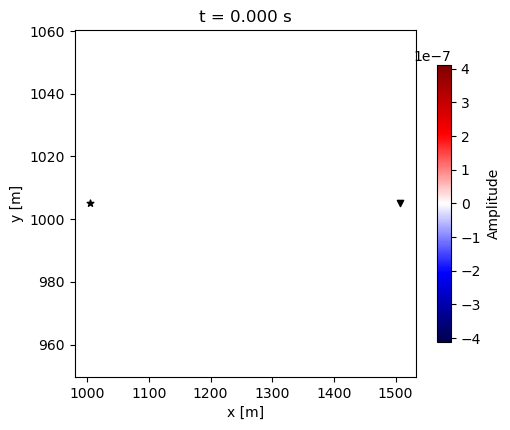

In [11]:
# Animate the wavefield over time (may take a moment)
from matplotlib import animation
from IPython.display import HTML

# Choose a stride to limit the number of frames for performance
plt.rcParams['animation.html'] = 'jshtml'
anim_stride = max(1, nt // 200)
plt.rcParams['animation.html'] = 'jshtml'
nframes = (nt - 1) // anim_stride

# Robust color scaling based on data distribution
arr = np.asarray(u.data[:])
af = np.abs(arr).ravel()
nz = af[af > 0]
af_use = nz if nz.size > 0 else af
vabs = float(np.percentile(af_use, vis_percentile)) if af_use.size > 0 else 1e-6
vabs = max(vabs * vis_clip_scale, 1e-9)
vmin, vmax = -vabs, vabs

fig, ax = plt.subplots(figsize=(5.5, 4.5))
ax.scatter([src_x], [src_y], c='k', s=25, marker='*')
ax.scatter([rec_x], [rec_y], c='k', s=20, marker='v')
cb = fig.colorbar(im, ax=ax, shrink=0.8, label='Amplitude')
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_title('t = 0.000 s')

def init():
    im.set_data(u.data[0].T)
    ax.set_title('t = 0.000 s')
    return (im,)

def update(i):
    plt.rcParams['animation.html'] = 'jshtml'
    idx = i * anim_stride
    arr_frame = np.asarray(u.data[idx])
    af = np.abs(arr_frame).ravel()
    nz = af[af > 0]
    af_use = nz if nz.size > 0 else af
    vabs_frame = float(np.percentile(af_use, vis_percentile)) if af_use.size > 0 else 1e-6
    vabs_frame = max(vabs_frame * vis_clip_scale, 1e-9)
    im.set_clim(-vabs_frame, vabs_frame)
    im.set_data(arr_frame.T)
    ax.set_title(f't = {idx*dt:.3f} s')
    return (im,)

anim = animation.FuncAnimation(fig, update, init_func=init, frames=nframes, interval=30, blit=False)
HTML(anim.to_jshtml())


## Notes
- Adjust `nx`, `ny`, `dx`, `dy`, and `tn` for different spatial/temporal resolutions.
- Increase `space_order` for higher accuracy (at additional cost).
- To avoid boundary reflections, consider adding absorbing layers or PML (not included here).
- If Devito is not installed, uncomment the `%pip install ...` cell at the top.